<a href="https://colab.research.google.com/github/WBjunior/Time_Series_Geracao_NE/blob/main/GeracaoNEtot__Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima
!pip install mapie

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import pandas.util.testing as tm
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from keras.models import Sequential
import tensorflow as tf
from keras.layers import LSTM
from keras.layers import Dense
from tensorflow import keras
import math
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import itertools
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from mapie.regression import MapieRegressor


<ipython-input-2-6e69e88428a1>:2: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Dados de geração - ONS

In [ ]:
geracao2023 = pd.read_csv('https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/geracao_usina_2_ho/GERACAO_USINA-2_2023_01.csv',sep=';')


In [ ]:
geracao2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463248 entries, 0 to 463247
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   din_instante            463248 non-null  object 
 1   id_subsistema           463248 non-null  object 
 2   nom_subsistema          463248 non-null  object 
 3   id_estado               463248 non-null  object 
 4   nom_estado              463248 non-null  object 
 5   cod_modalidadeoperacao  463248 non-null  object 
 6   nom_tipousina           463248 non-null  object 
 7   nom_tipocombustivel     462504 non-null  object 
 8   nom_usina               463248 non-null  object 
 9   ceg                     463248 non-null  object 
 10  val_geracao             462288 non-null  float64
dtypes: float64(1), object(10)
memory usage: 38.9+ MB


In [ ]:
geracao2023['din_instante'].astype('datetime64[ms]').describe(exclude=[object],datetime_is_numeric=True)

count                           463248
mean     2023-01-16 11:51:24.675163648
min                2023-01-01 00:00:00
25%                2023-01-08 18:00:00
50%                2023-01-16 12:00:00
75%                2023-01-24 06:00:00
max                2023-01-31 23:00:00
Name: din_instante, dtype: object

In [ ]:
geracao2023.describe(exclude=[object])

,val_geracao
count,462288.000000
mean,115.967232
std,424.723064
min,0.000000
25%,0.000000
50%,24.000000
75%,81.476000
max,9923.151000


In [ ]:
geracao2023.describe(include=[object])

,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg
count,463248,463248,463248,463248,463248,463248,463248,462504,463248,463248
unique,744,4,5,28,28,7,5,12,623,343
top,2023-01-31 23:00:00,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,São José,-
freq,625,188544,188544,58776,58776,188976,154752,154752,1488,203904


In [ ]:
geracao2023['nom_tipousina'].unique()

array(['HIDROELÉTRICA', 'TÉRMICA', 'EOLIELÉTRICA', 'FOTOVOLTAICA',
       'NUCLEAR'], dtype=object)

In [ ]:
geracao2023[(geracao2023['nom_tipousina']=='EOLIELÉTRICA')].describe(include=[object])

,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg
count,122328,122328,122328,122328,122328,122328,122328,122328,122328,122328
unique,744,4,4,12,12,4,1,2,165,13
top,2023-01-31 23:00:00,NE,NORDESTE,RN,RIO GRANDE DO NORTE,Conjunto de Usinas,EOLIELÉTRICA,Eólica,Conj. Paulino Neves,-
freq,165,108936,108936,39744,39744,102984,122328,121584,744,113400


#Dados de geração do nordeste em Janeiro de 2023

In [ ]:
geracaoNE = geracao2023[(geracao2023['id_subsistema']=='NE')]

In [ ]:
geracaoNE = geracaoNE[['din_instante','val_geracao']].sort_values(by='din_instante')

In [ ]:
geracaoNE=geracaoNE.groupby(by='din_instante').sum()

In [ ]:
geracaoNE.isna().sum()

val_geracao    0
dtype: int64

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=1,subplot_titles=("Geração"))
fig.add_trace(go.Scatter(x=geracaoNE.index, y=geracaoNE['val_geracao']),row=1,col=1)
fig.update_layout(title='MWmed',height=800,width=1500)
fig.show()

#Análise estatística de Séries temporais

## Teste ADF ( Augmented Dickey - Fuller )

## O teste ADF (Augmented Dickey-Fuller) é um teste estatístico utilizado para determinar se uma série temporal é estacionária ou não estacionária. Ele é comumente utilizado em econometria, finanças e outras áreas que lidam com dados de séries temporais. O termo "augmented" no nome do teste se refere ao fato de que ele é uma extensão do teste Dickey-Fuller original, que é um teste para verificar se uma série temporal tem uma raiz unitária. A adição de mais termos no modelo permite que o teste lide com mais tipos de séries temporais. A hipótese nula do teste ADF é que a série temporal possui uma raiz unitária, o que significa que ela não é estacionária. A hipótese alternativa é que a série não possui uma raiz unitária, o que significa que ela é estacionária. O teste usa uma estatística t para testar a significância estatística das diferenças entre os valores observados da série temporal e os valores que seriam esperados se a hipótese nula fosse verdadeira. Se o valor-p do teste ADF for menor do que um nível de significância pré-determinado, então a hipótese nula é rejeitada, indicando que a série temporal é estacionária. Se o valor-p for maior do que o nível de significância, a hipótese nula não é rejeitada, indicando que a série temporal é não-estacionária. 
## Teste de hipótese ADF
##    H0: Possui raiz unitária ( não é estacionaria )
##    H1: Não possui raiz unitaria 

In [ ]:
adf = adfuller(geracaoNE['val_geracao'])
print(f'Carga Norte p-valor: {adf[1]}')

Carga Norte p-valor: 0.7316677972052505


## O p-valor indica que a hipótese nula não pode ser rejeitada.

## Autocorrelação e Autocorrelação parcial

## A autocorrelação mede a correlação linear entre valores de uma série temporal em diferentes pontos no tempo. Em outras palavras, a autocorrelação mede a correlação entre um valor observado e um valor observado em um determinado número de períodos anteriores (lag). Por exemplo, a autocorrelação de lag 1 mede a correlação entre um valor observado e o valor observado um período anterior. A autocorrelação parcial, por sua vez, mede a correlação linear entre dois valores da série temporal, controlando os efeitos de outras defasagens intermediárias. Em outras palavras, a autocorrelação parcial de lag k mede a correlação entre um valor observado e o valor observado k períodos antes, levando em consideração o efeito das defasagens intermediárias. A autocorrelação e a autocorrelação parcial são comumente usadas para analisar a estrutura da série temporal e ajudar na seleção de modelos adequados para a previsão. Quando uma série temporal apresenta autocorrelação significativa, isso indica que os valores da série temporal estão correlacionados e podem ser usados para prever valores futuros. No entanto, é importante levar em consideração a autocorrelação parcial para garantir que as relações entre os valores da série temporal sejam adequadamente modeladas e para evitar a superestimação da correlação entre as variáveis.

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



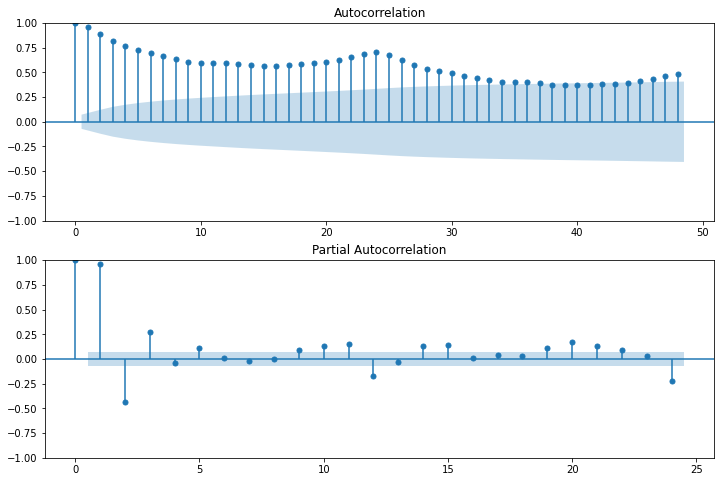

In [ ]:
dat = geracaoNE['val_geracao']
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dat.squeeze(), lags=48, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dat, lags=24, ax=ax2)

## Modelo ARIMA

## O modelo ARIMA (Autoregressive Integrated Moving Average) é um modelo estatístico utilizado para modelar séries temporais. Ele é uma combinação de modelos autoregressivos (AR) e de médias móveis (MA) com um termo adicional de integração (I) para lidar com a não estacionariedade da série temporal.

## O modelo ARIMA é composto por três parâmetros principais: p, d e q, que representam a ordem do modelo AR, a ordem de diferenciação e a ordem do modelo MA, respectivamente. O parâmetro p representa a ordem do modelo AR, que é o número de defasagens da série temporal que serão incluídas no modelo. Em outras palavras, o modelo AR assume que o valor atual da série temporal depende linearmente dos valores passados até um certo número de defasagens. O parâmetro q representa a ordem do modelo MA, que é o número de termos de média móvel que serão incluídos no modelo. O modelo MA assume que o valor atual da série temporal depende linearmente de um erro aleatório, que é uma combinação linear de erros passados até um certo número de defasagens. O parâmetro d representa a ordem de diferenciação, que é o número de vezes que a série temporal é diferenciada para torná-la estacionária. A diferenciação é realizada para remover tendências e sazonalidades da série temporal e torná-la estacionária.

## Para seleção do modelo ARIMA adequado a nossa série temporal vamos utilizar um grid onde os parametros p,q e d variam de 0 a 2. Para avaliação será utilizad a métrica BIC.

In [ ]:
p = d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
bic_lista = []
best_order = []
min_ = 1e10
for param in pdq:
    mod = sm.tsa.statespace.SARIMAX(geracaoNE['val_geracao'], order=param)
    results = mod.fit()
    bic = round(results.bic,2)
    if bic < min_ :
        min_ = bic
        best_order = 'ARIMA{} - BIC: {}'.format(param, bic)
    bic_lista.append('ARIMA{} - BIC: {}'.format(param, bic))

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inf

In [ ]:
bic_lista

['ARIMA(0, 0, 0) - BIC: 16457.42',
 'ARIMA(0, 0, 1) - BIC: 15458.55',
 'ARIMA(0, 0, 2) - BIC: 14750.45',
 'ARIMA(0, 1, 0) - BIC: 11858.32',
 'ARIMA(0, 1, 1) - BIC: 11678.88',
 'ARIMA(0, 1, 2) - BIC: 11684.92',
 'ARIMA(0, 2, 0) - BIC: 11953.88',
 'ARIMA(0, 2, 1) - BIC: 11885.68',
 'ARIMA(0, 2, 2) - BIC: 11657.88',
 'ARIMA(1, 0, 0) - BIC: 11887.09',
 'ARIMA(1, 0, 1) - BIC: 11683.56',
 'ARIMA(1, 0, 2) - BIC: 11689.91',
 'ARIMA(1, 1, 0) - BIC: 11741.92',
 'ARIMA(1, 1, 1) - BIC: 11685.17',
 'ARIMA(1, 1, 2) - BIC: 11650.66',
 'ARIMA(1, 2, 0) - BIC: 11956.96',
 'ARIMA(1, 2, 1) - BIC: 11725.69',
 'ARIMA(1, 2, 2) - BIC: 11663.8',
 'ARIMA(2, 0, 0) - BIC: 11750.11',
 'ARIMA(2, 0, 1) - BIC: 11689.97',
 'ARIMA(2, 0, 2) - BIC: 11696.71',
 'ARIMA(2, 1, 0) - BIC: 11677.56',
 'ARIMA(2, 1, 1) - BIC: 11683.44',
 'ARIMA(2, 1, 2) - BIC: 11651.96',
 'ARIMA(2, 2, 0) - BIC: 11860.68',
 'ARIMA(2, 2, 1) - BIC: 11657.51',
 'ARIMA(2, 2, 2) - BIC: 11663.38']

## O modelo selecionado foi o ARIMA(1,1,2) com BIC = 11650.66

In [ ]:
model = ARIMA(geracaoNE['val_geracao'], order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())#BIC: 11650.66'


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



                               SARIMAX Results                                
Dep. Variable:            val_geracao   No. Observations:                  744
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -5812.110
Date:                Wed, 08 Mar 2023   AIC                          11632.220
Time:                        19:29:41   BIC                          11650.663
Sample:                    01-01-2023   HQIC                         11639.330
                         - 01-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8125      0.035     23.110      0.000       0.744       0.881
ma.L1         -0.3700      0.041     -9.049      0.000      -0.450      -0.290
ma.L2         -0.5475      0.029    -19.106      0.0

## Podemos também aplicar uma análise de diagnóstico aos resultados do modelo através de uma análise de residuos, verificando sua distribuição e autocorrelação.

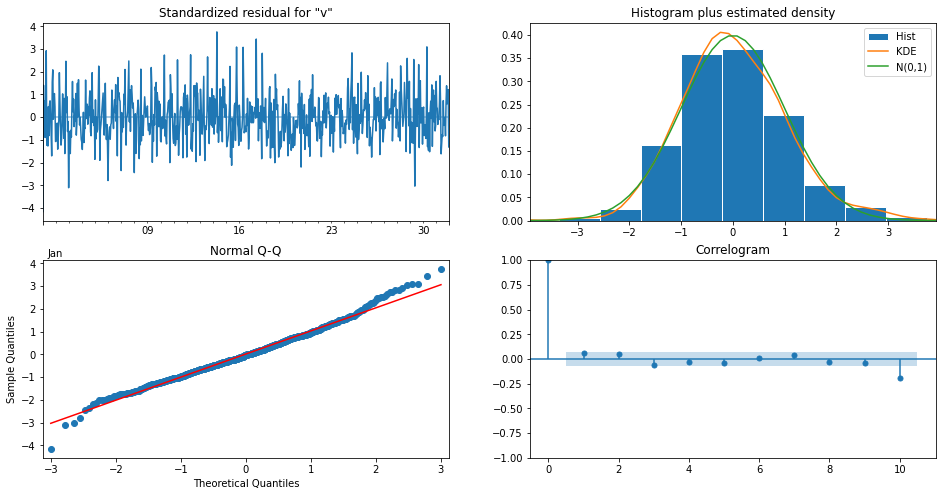

In [ ]:
model_fit.plot_diagnostics(figsize=(16,8));

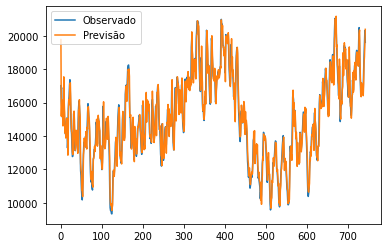

In [ ]:
fitted = pd.Series(model_fit.predict()).reset_index()
df = geracaoNE.reset_index()
fig, ax = plt.subplots()
ax.plot(df['val_geracao'].iloc[1:], label='Observado')
ax.plot(fitted['predicted_mean'].iloc[1:], label='Previsão')
plt.legend()

## Aplicação de Machine Learning a Séries temporais

## Os modelos de ML aplicados foram: SVR (Support Vector Regression), MLP (Multi-Layer Perceptron), LGBM (LightGBM) e LSTM (Long Short-Term Memory). Como  métricas de avaliação foram utilizados o MSE (Mean Squared Error), o MAE (Mean Absolute Error) e o MAPE (Mean Absolute Percentage Error). O MSE mede a média do quadrado das diferenças entre os valores previstos e os valores reais da série temporal, enquanto o MAE mede a média das diferenças absolutas entre os valores previstos e os valores reais. Já o MAPE mede a porcentagem média de diferença absoluta entre os valores previstos e os valores reais.

In [ ]:
def windonXy(dat,n_lags):
  X = pd.DataFrame()
  y = list()
  for i in range(len(dat)):
    end_ix = i + n_lags
    if end_ix > len(dat)-1:
      break
    n = np.array(dat[i:end_ix])
    df = (pd.DataFrame(n)).T
    X= pd.concat([X,df],axis=0)
    y.append(dat[end_ix])
  y= pd.DataFrame(y)
  return(X,y)
  


In [ ]:
st_train, st_test = train_test_split(geracaoNE['val_geracao'],shuffle=False, test_size=0.25)
st_train = np.array(st_train)
st_test = np.array(st_test)
min = np.min(st_train)
max = np.max(st_train)
st_train = (st_train - min) / (max - min)
st_test = (st_test - min) / (max - min)

In [ ]:
X_train,y_train = windonXy(st_train,24)
X_test,y_test = windonXy(st_test,24)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(534, 24)
(534, 1)
(162, 24)
(162, 1)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.731627,0.659203,0.577821,0.549911,0.540754,0.493904,0.489982,0.648703,0.641119,0.550780,...,0.474623,0.492530,0.449158,0.339306,0.380870,0.539708,0.582440,0.605207,0.662901,0.689669
0,0.659203,0.577821,0.549911,0.540754,0.493904,0.489982,0.648703,0.641119,0.550780,0.455516,...,0.492530,0.449158,0.339306,0.380870,0.539708,0.582440,0.605207,0.662901,0.689669,0.619117
0,0.577821,0.549911,0.540754,0.493904,0.489982,0.648703,0.641119,0.550780,0.455516,0.439209,...,0.449158,0.339306,0.380870,0.539708,0.582440,0.605207,0.662901,0.689669,0.619117,0.515847
0,0.549911,0.540754,0.493904,0.489982,0.648703,0.641119,0.550780,0.455516,0.439209,0.410856,...,0.339306,0.380870,0.539708,0.582440,0.605207,0.662901,0.689669,0.619117,0.515847,0.440871
0,0.540754,0.493904,0.489982,0.648703,0.641119,0.550780,0.455516,0.439209,0.410856,0.419064,...,0.380870,0.539708,0.582440,0.605207,0.662901,0.689669,0.619117,0.515847,0.440871,0.410557


## MLP regressor

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(50, input_shape=(24,), activation='relu'))
model_mlp.add(Dense(50, activation='relu'))
model_mlp.add(Dense(50, activation='relu'))
model_mlp.add(Dense(1, activation='linear'))
callbacks = [
    ReduceLROnPlateau(patience=10, factor=0.5, verbose=True),
    ModelCheckpoint("best_model_mlp.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', save_freq=1)]
# Configurando e treiando o modelo
model_mlp.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])
model_mlp.fit(X_train, y_train, epochs=50, batch_size=1, verbose=True, validation_split=0.25,callbacks=callbacks)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 44: loss did not improve from 0.00067

Epoch 44: loss did not improve from 0.00067

Epoch 44: loss did not improve from 0.00067
310/400 [======================>.......] - ETA: 0s - loss: 0.0389 - mean_squared_error: 0.0025
Epoch 44: loss did not improve from 0.00067

Epoch 44: loss did not improve from 0.00067

Epoch 44: loss did not improve from 0.00067

Epoch 44: loss did not improve from 0.00067

Epoch 44: loss did not improve from 0.00067

Epoch 44: loss did not improve from 0.00067

Epoch 44: loss did not improve from 0.00067

Epoch 44: loss did not improve from 0.00067

Epoch 44: loss did not improve from 0.00067

Epoch 44: loss did not improve from 0.00067
320/400 [=======================>......] - ETA: 0s - loss: 0.0386 - mean_squared_error: 0.0025
Epoch 44: loss did not improve from 0.00067

Epoch 44: loss did not improve from 0.00067

Epoch 44: loss did not improve from 0.00067

Epoch 44: loss did not improve fr

In [ ]:
model_mlp.load_weights('best_model_mlp.hdf5')
pred_mlp = model_mlp.predict(X_test)

6/6 [==============================] - 0s 2ms/step


In [ ]:
results = {}

print('MLP model Results')
results['MLP'] = {'mse': mean_squared_error(pred_mlp, y_test),
                  'mae': mean_absolute_error(pred_mlp, y_test),
                  'mape':mean_absolute_percentage_error(pred_mlp, y_test)}
results

MLP model Results


{'MLP': {'mse': 0.003234977257735753,
  'mae': 0.04369475587181178,
  'mape': 0.0766240223561974}}

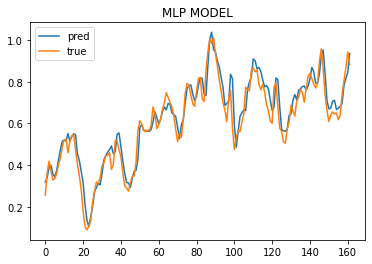

In [ ]:
fig, ax = plt.subplots()
ax.plot(pred_mlp, label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.title('MLP MODEL')
plt.legend()

## LSTM regressor

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print('X_train: ', X_train.shape)
print('X_test:  ', X_test.shape)

X_train:  (534, 24, 1)
X_test:   (162, 24, 1)


In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(120, activation='relu', return_sequences=True, input_shape=(24,1)))
model_lstm.add(tf.keras.layers.Dropout(0.3))
model_lstm.add(LSTM(50, activation='relu'))
model_lstm.add(tf.keras.layers.Dropout(0.3))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 120)           58560     
                                                                 
 dropout (Dropout)           (None, 24, 120)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                34200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 92,811
Trainable params: 92,811
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [
    ReduceLROnPlateau(patience=10, factor=0.5, verbose=True),
    ModelCheckpoint("best_model_lstm.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', save_freq=1)]

In [ ]:
model_lstm.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=50, verbose=1, callbacks=callbacks)

Epoch 1/50

Epoch 1: loss improved from inf to 0.25417, saving model to best_model_lstm.hdf5
 1/17 [>.............................] - ETA: 48s - loss: 0.2542
Epoch 1: loss improved from 0.25417 to 0.21073, saving model to best_model_lstm.hdf5
 2/17 [==>...........................] - ETA: 1s - loss: 0.2107 
Epoch 1: loss improved from 0.21073 to 0.20697, saving model to best_model_lstm.hdf5
 3/17 [====>.........................] - ETA: 1s - loss: 0.2070
Epoch 1: loss did not improve from 0.20697
 4/17 [======>.......................] - ETA: 1s - loss: 0.2074
Epoch 1: loss improved from 0.20697 to 0.19489, saving model to best_model_lstm.hdf5
 5/17 [=======>......................] - ETA: 1s - loss: 0.1949
Epoch 1: loss improved from 0.19489 to 0.17785, saving model to best_model_lstm.hdf5
 6/17 [=========>....................] - ETA: 0s - loss: 0.1778
Epoch 1: loss improved from 0.17785 to 0.16436, saving model to best_model_lstm.hdf5
 7/17 [===========>..................] - ETA: 0s - lo

In [ ]:
model_lstm.load_weights('best_model_lstm.hdf5')
pred_lstm = model_lstm.predict(X_test)

6/6 [==============================] - 0s 8ms/step


In [ ]:
print('LSTM model Results')
results['LSTM'] = {'mse': mean_squared_error(pred_lstm, y_test),
                  'mae': mean_absolute_error(pred_lstm, y_test),
                  'mape':mean_absolute_percentage_error(pred_lstm, y_test)}
results

LSTM model Results


{'MLP': {'mse': 0.003234977257735753,
  'mae': 0.04369475587181178,
  'mape': 0.0766240223561974},
 'LSTM': {'mse': 0.008040517372466234,
  'mae': 0.07269689632233525,
  'mape': 0.14168762735965318}}

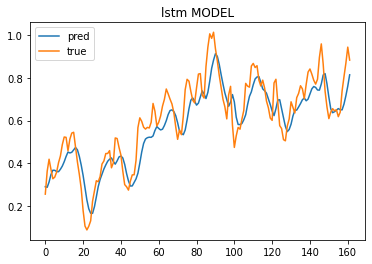

In [ ]:
fig, ax = plt.subplots()
ax.plot(pred_lstm, label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.title('lstm MODEL')
plt.legend()

##LGBM regressor

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1]))

In [ ]:
model_LGBM = LGBMRegressor()


In [ ]:
model_LGBM.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          verbose=50,
          eval_metric='rmse',
          early_stopping_rounds=20)

Training until validation scores don't improve for 20 rounds.
[50]	valid_0's rmse: 0.0614359	valid_0's l2: 0.00377437
[100]	valid_0's rmse: 0.0608019	valid_0's l2: 0.00369688
Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 0.0606972	valid_0's l2: 0.00368415


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LGBMRegressor()

In [ ]:
pred_LGBM = model_LGBM.predict(X_test)

In [ ]:
print('LGBM model Results')
results['LGBM'] = {'mse': mean_squared_error(pred_LGBM, y_test),
                  'mae': mean_absolute_error(pred_LGBM, y_test),
                  'mape':mean_absolute_percentage_error(pred_LGBM, y_test)}
results

LGBM model Results


{'MLP': {'mse': 0.003234977257735753,
  'mae': 0.04369475587181178,
  'mape': 0.0766240223561974},
 'LSTM': {'mse': 0.008040517372466234,
  'mae': 0.07269689632233525,
  'mape': 0.14168762735965318},
 'LGBM': {'mse': 0.0036841520042503184,
  'mae': 0.046490840215175175,
  'mape': 0.08625817146208868}}

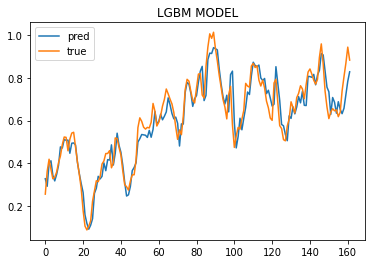

In [ ]:
fig,ax = plt.subplots()
ax.plot(pred_LGBM, label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.title('LGBM MODEL')
plt.legend()

## SVR regressor

In [ ]:
param = {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),'C' : [1,5,10],'degree' : [3,8],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')}
model_SVR = GridSearchCV(SVR(),param,cv=5)

In [ ]:
model_SVR.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: Dat

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [1, 5, 10], 'coef0': [0.01, 10, 0.5],
                         'degree': [3, 8], 'gamma': ('auto', 'scale'),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')})

In [ ]:
pred_SVR = model_SVR.predict(X_test)

In [ ]:
print('SVR model Results')
results['SVR'] = {'mse': mean_squared_error(pred_SVR, y_test),
                  'mae': mean_absolute_error(pred_SVR, y_test),
                  'mape':mean_absolute_percentage_error(pred_SVR, y_test)}
results

SVR model Results


{'MLP': {'mse': 0.003234977257735753,
  'mae': 0.04369475587181178,
  'mape': 0.0766240223561974},
 'LSTM': {'mse': 0.008040517372466234,
  'mae': 0.07269689632233525,
  'mape': 0.14168762735965318},
 'LGBM': {'mse': 0.0036841520042503184,
  'mae': 0.046490840215175175,
  'mape': 0.08625817146208868},
 'SVR': {'mse': 0.0026444878875929454,
  'mae': 0.040567308445866576,
  'mape': 0.0747836688725313}}

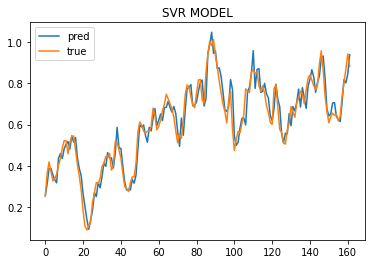

In [ ]:
fig,ax = plt.subplots()
ax.plot(pred_SVR, label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.title('SVR MODEL')
plt.legend()

## Intervalo de Predição para SVR 

In [ ]:
model = MapieRegressor(
    model_SVR, 
    cv="prefit",
    method='base', agg_function=None, n_jobs=-1,
).fit(X_test, y_test)

forecasts = model.predict(X_test, alpha=0.05, ensemble=False)
y_test,y_ic = forecasts

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



##Ensemble

## O Ensemble é uma técnica de aprendizado de máquina que combina vários modelos para melhorar a precisão e a estabilidade das previsões. A ideia por trás do ensemble é que a combinação de vários modelos fracos pode produzir um modelo forte que pode fazer previsões mais precisas. A ideia do ensemble aplicado foi utilizar o Intervalo de Predição obtido a partir do SVR como critério para calculo da média dos preditores.

In [ ]:
def ensemble(yhat1, yhat2, yhat3, yhat4, upper, lower):
    if upper <= lower:
        raise ValueError("Upper bound must be greater than lower bound.")
    
    yhats = [yhat1, yhat2, yhat3, yhat4]
    yhats_in_interval = [yhat for yhat in yhats if lower < yhat < upper]
    
    if not yhats_in_interval:
        return None
    out = sum(yhats_in_interval) / len(yhats_in_interval)
    return out.item()



In [ ]:
dat =[ensemble(yhat1,yhat2,yhat3,yhat4,upper,lower) for yhat1,yhat2,yhat3,yhat4,upper,lower in zip(pred_LGBM,pred_SVR,pred_mlp,pred_lstm,y_ic[:,1,0],y_ic[:,0,0])]

In [ ]:
print('Ensemble model Results')
results['Ensemble'] = {'mse': mean_squared_error(dat, y_test),
                  'mae': mean_absolute_error(dat, y_test),
                  'mape':mean_absolute_percentage_error(dat, y_test)}
results

Ensemble model Results


{'MLP': {'mse': 0.003234977257735753,
  'mae': 0.04369475587181178,
  'mape': 0.0766240223561974},
 'LSTM': {'mse': 0.008040517372466234,
  'mae': 0.07269689632233525,
  'mape': 0.14168762735965318},
 'LGBM': {'mse': 0.0036841520042503184,
  'mae': 0.046490840215175175,
  'mape': 0.08625817146208868},
 'SVR': {'mse': 0.0026444878875929454,
  'mae': 0.040567308445866576,
  'mape': 0.0747836688725313},
 'Ensemble': {'mse': 0.0004891377136526729,
  'mae': 0.018458247897321943,
  'mape': 0.03403350594204156}}

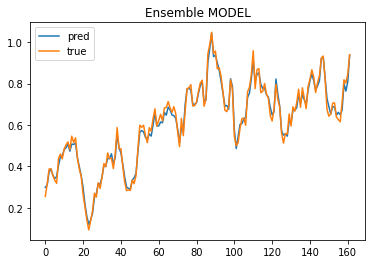

In [ ]:
fig,ax = plt.subplots()
ax.plot(dat, label='pred')
ax.plot(y_test, label='true')
plt.title('Ensemble MODEL')
plt.legend()

##Resultado

In [ ]:
plt_y = y_test
plt_mlp = np.array(pred_mlp)
plt_mlp = list(itertools.chain(*plt_mlp))
plt_lstm = np.array(pred_lstm)
plt_lstm =list(itertools.chain(*plt_lstm))
plt_LGBM =np.array(pred_LGBM)
plt_SVR =np.array(pred_SVR)
plt_Emsemble = dat

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(plt_SVR)), y=plt_SVR,name='SVR'))
fig.add_trace(go.Scatter(x=np.arange(len(plt_LGBM)), y=plt_LGBM,name='LGBM'))
fig.add_trace(go.Scatter(x=np.arange(len(plt_mlp)), y=plt_mlp,name='MLP'))
fig.add_trace(go.Scatter(x=np.arange(len(plt_lstm)), y=plt_lstm,name='LSTM'))
fig.add_trace(go.Scatter(x=np.arange(len(plt_Emsemble)), y=plt_Emsemble,name='Emsemble'))
fig.add_trace(go.Scatter(x=np.arange(len(plt_y)), y=plt_y,name='true',mode='markers'))
fig.add_trace(go.Scatter(x=np.arange(len(y_ic[:,0,0])), y=y_ic[:,0,0],name='lower',marker=dict(color="#444"),line=dict(width=0),mode='lines',fillcolor='rgba(190, 190, 190, 0.3)',fill='tonexty'))
fig.add_trace(go.Scatter(x=np.arange(len(y_ic[:,1,0])), y=y_ic[:,1,0],name='upper',marker=dict(color="#444"),line=dict(width=0),mode='lines',fillcolor='rgba(190, 190, 190, 0.3)',fill='tonexty'))
fig.update_layout(title='Models',height=800,width=1500)
fig.show()

In [ ]:
invn = (max - min) + min 
y_plt = np.array([k*invn for k in y_test])
pred_mlp = np.array([k*invn for k in pred_mlp])
#pred_mlp = list(itertools.chain(*pred_mlp))
pred_lstm = np.array([k* invn for k in pred_lstm])
#pred_lstm =list(itertools.chain(*pred_lstm))
pred_LGBM =np.array([k* invn for k in pred_LGBM])
#pred_LGBM =list(itertools.chain(*pred_LGBM))
pred_SVR =np.array([k* invn for k in pred_SVR])
#pred_SVR =list(itertools.chain(*pred_SVR))
pred_Ensemble =np.array([k* invn for k in dat])
#pred_Ensemble =dat

In [ ]:
pred_mlp = list(itertools.chain(*pred_mlp))
pred_lstm =list(itertools.chain(*pred_lstm))

In [ ]:
fig = go.Figure()
#y_plt= list(itertools.chain(*y_plt))
y_hat=np.array(fitted.iloc[585:791])
fig = make_subplots(rows=1, cols=5,subplot_titles=("MLP", "LSTM","LGBM","SVR","Emsemble"))
fig.add_trace(go.Scatter(x=np.arange(len(pred_mlp)), y=pred_mlp,name='pred'),row=1,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(y_plt)), y=y_plt,name='true'),row=1,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(pred_lstm)), y=pred_lstm,name='pred'),row=1,col=2)
fig.add_trace(go.Scatter(x=np.arange(len(y_plt)), y=y_plt,name='true'),row=1,col=2)
fig.add_trace(go.Scatter(x=np.arange(len(pred_LGBM)), y=pred_LGBM,name='pred'),row=1,col=3)
fig.add_trace(go.Scatter(x=np.arange(len(y_plt)), y=y_plt,name='true'),row=1,col=3)
fig.add_trace(go.Scatter(x=np.arange(len(pred_SVR)), y=pred_SVR,name='pred'),row=1,col=4)
fig.add_trace(go.Scatter(x=np.arange(len(y_plt)), y=y_plt,name='true'),row=1,col=4)
fig.add_trace(go.Scatter(x=np.arange(len(pred_Ensemble)), y=pred_SVR,name='pred'),row=1,col=5)
fig.add_trace(go.Scatter(x=np.arange(len(y_plt)), y=y_plt,name='true'),row=1,col=5)
fig.update_layout(title='Models',height=800,width=1500)
fig.show()

In [ ]:
pd.DataFrame(results)

,MLP,LSTM,LGBM,SVR,Ensemble
mse,0.003235,0.008041,0.003684,0.002644,0.000489
mae,0.043695,0.072697,0.046491,0.040567,0.018458
mape,0.076624,0.141688,0.086258,0.074784,0.034034


#Análise de resíduos

In [ ]:
diff_SVR   = y_plt - pred_SVR
diff_Ensemble   = y_plt - pred_Ensemble  
diff_mlp   = y_plt - pred_mlp
diff_lstm  = y_plt - pred_lstm
diff_LGBM   = y_plt - pred_LGBM
#diff_arima =list(itertools.chain(*diff_arima)) 
#diff_mlp =list(itertools.chain(*diff_mlp)) 
#diff_lstm =list(itertools.chain(*diff_lstm)) 
#diff_cnn =list(itertools.chain(*diff_cnn)) 

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=5,subplot_titles=("SVR","MLP","LSTM","LGBM","Ensemble"))
fig.add_trace(go.Bar(x=np.arange(len(diff_SVR)), y=diff_SVR,name='Erro SVR'),row=1,col=1)
fig.add_trace(go.Bar(x=np.arange(len(diff_mlp)), y=diff_mlp,name='Erro MLP'),row=1,col=2)
fig.add_trace(go.Bar(x=np.arange(len(diff_lstm)), y=diff_lstm,name='Erro LSTM'),row=1,col=3)
fig.add_trace(go.Bar(x=np.arange(len(diff_LGBM)), y=diff_LGBM,name='Erro LGBM'),row=1,col=4)
fig.add_trace(go.Bar(x=np.arange(len(diff_Ensemble)), y=diff_Ensemble,name='Erro Ensemble'),row=1,col=5)
fig.update_layout(height=800,width=1500)
fig.update_traces(marker_color='rgb(225,0,0)', marker_line_color='rgb(190,190,190)')
fig.show()

## Forecast

In [ ]:
npred = 5
dat = np.array(geracaoNE['val_geracao'])
x1 = np.append(np.array(X_test)[161,1:],np.array(y_test)[161])
x2=x4=x3=x1
pred_SVR = []
pred_MLP = []
pred_LGBM = []
pred_LSTM = []
for i in range(5):
  x1_p = x1[i:]
  x2_p = x2[i:]
  x3_p = x3[i:]
  x4_p = x4[i:] 
  x1_p = x1_p.reshape((1,24))
  x2_p = x2_p.reshape((1,24))
  x3_p = x3_p.reshape((1,24))
  x4_p = x4_p.reshape((1,24,1))
  y1 = model_SVR.predict(x1_p)
  y2 = model_mlp.predict(x2_p)
  y3 = model_LGBM.predict(x3_p)
  y4 = model_lstm.predict(x4_p)
  x1 = np.append(x1,y1)
  x2 = np.append(x2,y2)
  x3 = np.append(x3,y3)
  x4 = np.append(x4,y4)
  pred_SVR = np.append(pred_SVR,y1)
  pred_MLP = np.append(pred_MLP,y2)
  pred_LGBM = np.append(pred_LGBM,y3)
  pred_LSTM = np.append(pred_LSTM,y4)
  
  


1/1 [==============================] - 0s 23ms/step


In [ ]:
pred_MLP =np.array([k* invn for k in pred_MLP])
#pred_MLP =list(itertools.chain(*pred_MLP))
pred_SVR =np.array([k* invn for k in pred_SVR])
#pred_SVR =list(itertools.chain(*pred_SVR))
pred_LGBM =np.array([k* invn for k in pred_LGBM])
#pred_LGBM =list(itertools.chain(*pred_LGBM))
pred_LSTM =np.array([k* invn for k in pred_LSTM])
#pred_LSTM =list(itertools.chain(*pred_LSTM))
x1 = np.arange(len(y_plt),len(y_plt)+5,1)


In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=4,subplot_titles=("SVR","MLP","LGBM",'LSTM'))
fig.add_trace(go.Scatter(x=np.arange(len(y_plt)), y=y_plt,name='true'),row=1,col=1)
fig.add_trace(go.Scatter(x=x1, y=pred_SVR,name='forecast'),row=1,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(y_plt)), y=y_plt,name='true'),row=1,col=2)
fig.add_trace(go.Scatter(x=x1, y=pred_MLP,name='forecast'),row=1,col=2)
fig.add_trace(go.Scatter(x=np.arange(len(y_plt)), y=y_plt,name='true'),row=1,col=3)
fig.add_trace(go.Scatter(x=x1, y=pred_LGBM,name='forecast'),row=1,col=3)
fig.add_trace(go.Scatter(x=np.arange(len(y_plt)), y=y_plt,name='true'),row=1,col=4)
fig.add_trace(go.Scatter(x=x1, y=pred_LSTM,name='forecast'),row=1,col=4)
fig.update_layout(title='Models',height=800,width=1500)
fig.show()